# Libraries

In [1]:
import sys
sys.path.append('..') 
sys.path.append('.') 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import tarfile
from tqdm import tqdm

from ultralytics import YOLOWorld

import cv2
from cv2 import dnn_superres

import pandas as pd
import numpy as np

import tensorflow as tf

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from adjustText import adjust_text

from pathlib import Path

from matplotlib import rcParams


In [4]:
from functions.cardetection import detect_cars
from functions.imgprocessing import visualize_random_batch, crop_detected_vehicles, load_image_as_bytes
from functions.superresolution import superresolve_images

In [5]:
# Enable LaTeX rendering for elegant text, comment if no available TeX distribution
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
plt.rcParams['axes.axisbelow'] = True




# Define colors
box_color = (86, 0, 50)  # Dark red for bounding boxes
text_color = (86, 0, 50)  # Same color for text

# Global variables

In [6]:
IMAGE_EXTENSIONS = (
        '.bmp', '.dib',           # Windows bitmaps
        '.jpeg', '.jpg', '.jpe',  # JPEG files
        '.jp2',                   # JPEG 2000 files
        '.png',                   # Portable Network Graphics
        '.webp',                  # WebP files
        '.avif',                  # AVIF files
        '.pbm', '.pgm', '.ppm', '.pxm', '.pnm',  # Portable image formats
        '.pfm',                   # PFM files
        '.sr', '.ras',            # Sun rasters
        '.tiff', '.tif',          # TIFF files
        '.exr',                   # OpenEXR Image files
        '.hdr', '.pic'            # Radiance HDR
    )

In [27]:
ORIGINAL_IMAGE_DIR = "sample/article_oblique"
ORIGINAL_IMAGE_PATHS = [os.path.join(ORIGINAL_IMAGE_DIR, f) for f in os.listdir(ORIGINAL_IMAGE_DIR) if f.lower().endswith(IMAGE_EXTENSIONS)]
print(f"{len(ORIGINAL_IMAGE_PATHS)} image(s) found in {ORIGINAL_IMAGE_DIR} folder.")

3 image(s) found in sample/article_oblique folder.


In [28]:
OUTPUT_DIR = f"outputs/{ORIGINAL_IMAGE_DIR.split('/')[-1]}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DETECTION_DIR = f"{OUTPUT_DIR}/0_detection"
LABEL_DIR = f"{OUTPUT_DIR}/0_detection/labels"
CROPPED_DIR = f"{OUTPUT_DIR}/1_cropped_vehicles"

SUPERRESOLVED_DIR = f"{OUTPUT_DIR}/2_super_resolution"
sr_csv_path = f"{OUTPUT_DIR}/2_super_resolution/rescaling_stats.csv"

CLASSIFICATION_DIR = f"{OUTPUT_DIR}/3_classification"
ic_csv_path= f"{OUTPUT_DIR}/3_classification/classification_results.csv"

ANNOTATED_IMG_DIR = f"{OUTPUT_DIR}/annotated_images/"


dirs = [LABEL_DIR, CROPPED_DIR, SUPERRESOLVED_DIR, CLASSIFICATION_DIR, ANNOTATED_IMG_DIR]

for dir in dirs:
    os.makedirs(dir, exist_ok=True)

# Vehicle Detection 
Detect vehicles in street-level images using a pre-trained YOLO-World model with SAHI.

## Initialize YOLO-World model
Ref: https://doi.org/10.48550/arXiv.2401.17270

In [29]:
model = YOLOWorld("models/yolov8x-world.pt")  
model.set_classes(["car"]) 

## Use YOLO-World with SAHI for Sliced Inference

- https://github.com/obss/sahi
- https://doi.org/10.1109/ICIP46576.2022.9897990
- https://doi.org/10.5281/zenodo.5718950
      

In [31]:
from PIL import Image

IS_STREETVIEW = False

for image_path in tqdm(ORIGINAL_IMAGE_PATHS, desc="Processing images"):
    print(f"Processing {image_path}...")
    
    if IS_STREETVIEW:
        slice_height, slice_width = Image.open(image_path).size
    else:
        slice_height, slice_width = 320, 320  # depending on the expected minimal object size

    detect_cars(
        image_path=image_path,
        output_dir=Path(DETECTION_DIR),
        model=model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=0.1,
        overlap_width_ratio=0.1,
        confidence_threshold=0.25,
        save_labels=True,
        save_visuals=True,
        verbose=True,
    )

Processing images:   0%|          | 0/3 [00:00<?, ?it/s]

Processing sample/article_oblique\Echternach-Luxembourg-July-2021-VilleEchternach_0.jpg...
Performing prediction on 12 slices.


Processing images:  33%|███▎      | 1/3 [00:29<00:58, 29.42s/it]

Labels saved to outputs\article_oblique\0_detection\labels
Visual results saved to outputs\article_oblique\0_detection\visuals\Echternach-Luxembourg-July-2021-VilleEchternach_0.jpg
Number of detections: 6
Detection 1: Class: car, Confidence (Pred. Score) 0.64, BBox=[839.2335205078125, 355.1527404785156, 873.5716857910156, 378.45835876464844]
Detection 2: Class: car, Confidence (Pred. Score) 0.60, BBox=[936.3667602539062, 420.12349700927734, 960.0, 446.9436492919922]
Detection 3: Class: car, Confidence (Pred. Score) 0.54, BBox=[596.9931335449219, 114.1829833984375, 620.4847640991211, 127.51667022705078]
Detection 4: Class: car, Confidence (Pred. Score) 0.50, BBox=[578.8812255859375, 156.38307189941406, 607.1931762695312, 169.03050231933594]
Detection 5: Class: car, Confidence (Pred. Score) 0.44, BBox=[829.1888732910156, 665.1194763183594, 848.5467834472656, 683.3624877929688]
Detection 6: Class: car, Confidence (Pred. Score) 0.32, BBox=[640, 135.8748779296875, 657.2613468170166, 155.678

Processing images:  67%|██████▋   | 2/3 [00:58<00:29, 29.49s/it]

Labels saved to outputs\article_oblique\0_detection\labels
Visual results saved to outputs\article_oblique\0_detection\visuals\Echternach-Luxembourg-July-2021-VilleEchternach_1.jpg
Number of detections: 2
Detection 1: Class: car, Confidence (Pred. Score) 0.56, BBox=[828.5958862304688, 518.8615112304688, 842.8773193359375, 530.0018310546875]
Detection 2: Class: car, Confidence (Pred. Score) 0.47, BBox=[586.8469800949097, 688.9462890625, 601.5467338562012, 700.0416259765625]
Processing sample/article_oblique\Echternach-Luxembourg-July-2021-VilleEchternach_2.jpg...


Processing images:  67%|██████▋   | 2/3 [00:58<00:29, 29.49s/it]

Performing prediction on 12 slices.


Processing images: 100%|██████████| 3/3 [01:28<00:00, 29.44s/it]

Labels saved to outputs\article_oblique\0_detection\labels
Visual results saved to outputs\article_oblique\0_detection\visuals\Echternach-Luxembourg-July-2021-VilleEchternach_2.jpg
Number of detections: 3
Detection 1: Class: car, Confidence (Pred. Score) 0.76, BBox=[107.33212280273438, 432.6334533691406, 128.0810089111328, 455.5084686279297]
Detection 2: Class: car, Confidence (Pred. Score) 0.54, BBox=[119.23458862304688, 453.74231719970703, 140.46908569335938, 476.48548889160156]
Detection 3: Class: car, Confidence (Pred. Score) 0.31, BBox=[96.67207336425781, 366.6129455566406, 115.47085571289062, 384.4093017578125]


### Visualize car detection results

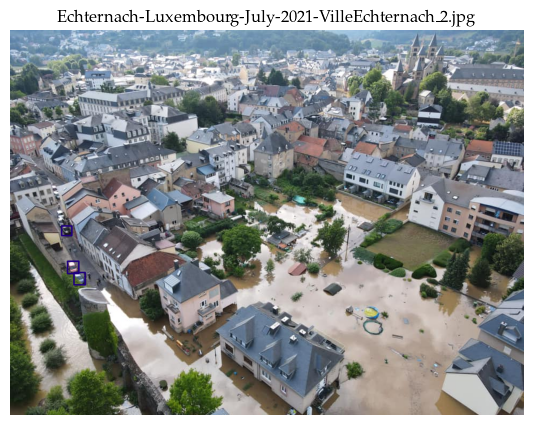

In [32]:
visualize_random_batch(ORIGINAL_IMAGE_DIR, LABEL_DIR, batch_size=1, show_class=False)

# Region Extraction & Contextual Expansion 
Crop detected vehicle regions with a 20% bounding box enlargement to include flood indicators and contextual cues.

In [33]:
crop_detected_vehicles(ORIGINAL_IMAGE_DIR, LABEL_DIR, CROPPED_DIR, scale=1.2, verbose=False)
print(f'{len([f for f in os.listdir(CROPPED_DIR) if os.path.isfile(os.path.join(CROPPED_DIR, f))])} images saved')

Cropping Vehicles: 100%|██████████| 3/3 [00:00<00:00, 58.00image/s]

11 images saved


# Super-Resolution Enhancement 
Apply pre-trained Enhanced Deep Super-Resolution (EDSR) networks to improve image quality.
https://doi.org/10.48550/arXiv.1707.02921 

In [34]:
from cv2 import dnn_superres

In [35]:
# Initialize and load Super-Resolution models with different scales
sr_models = {
    4: dnn_superres.DnnSuperResImpl_create(),
    3: dnn_superres.DnnSuperResImpl_create(),
    2: dnn_superres.DnnSuperResImpl_create()
}

for scale, sr in sr_models.items():
    model_path = f"./models/EDSR_x{scale}.pb"  # TODO ADD MODEL DOWNLOAD
    sr.readModel(model_path)
    sr.setModel("edsr", scale)

In [36]:
folder_stats = {
    'min_size': float('inf'),
    'max_size': 0,
    'below_200_count': 0,
    'below_100_count': 0,
    'below_50_count': 0
}


image_paths = [os.path.join(CROPPED_DIR, f) for f in os.listdir(CROPPED_DIR) if f.lower().endswith(IMAGE_EXTENSIONS)]

for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is None:
        continue

    height, width = image.shape[:2]
    size = max(height, width)

    folder_stats['min_size'] = min(folder_stats['min_size'], size)
    folder_stats['max_size'] = max(folder_stats['max_size'], size)
    folder_stats['below_200_count'] += (height < 200 or width < 200)
    folder_stats['below_100_count'] += (height < 100 or width < 100)
    folder_stats['below_50_count'] += (height < 50 or width < 50)

print("-" * 50)
print(f"Folder: {CROPPED_DIR}")
print(f"Min size: {folder_stats['min_size']} pixels")
print(f"Max size: {folder_stats['max_size']} pixels")
print(f"Images below 200 pixels: {folder_stats['below_200_count']}")
print(f"Images below 100 pixels: {folder_stats['below_100_count']}")
print(f"Images below 50 pixels: {folder_stats['below_50_count']}")
print("-" * 50)


--------------------------------------------------
Folder: outputs/article_oblique/1_cropped_vehicles
Min size: 17 pixels
Max size: 42 pixels
Images below 200 pixels: 11
Images below 100 pixels: 11
Images below 50 pixels: 11
--------------------------------------------------


In [37]:
superresolve_images(CROPPED_DIR, SUPERRESOLVED_DIR, sr_models, IMAGE_EXTENSIONS, sr_csv_path)

Rescaling Images: 11image [00:51,  4.68s/image]


# Flood Depth Classification 
Classify images based on flood depth levels using the fine-tuned ResNet50 model.

In [38]:
# TODO ADD MODEL DOWNLOAD
classifier_path = "models/classifier.tar.gz"
extract_dir = "models/classifier"

os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(classifier_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print(f"Model extracted to {extract_dir}")

Model extracted to models/classifier


In [39]:
model_path = "models/classifier/1"

model = tf.saved_model.load(model_path)


print("Available signatures:", list(model.signatures.keys()))
inference_fn = model.signatures["serving_default"]
print("Input Signature:", inference_fn.structured_input_signature)
print("Output Signature:", inference_fn.structured_outputs)

labels_info_path = "models/classifier/labels_info.json"

with open(labels_info_path, "r") as f:
    labels_info = json.load(f)

CLASS_LABELS = labels_info["labels"]

print("Class Labels:", CLASS_LABELS)


02/26/2025 18:31:58 - INFO - absl -   Fingerprint not found. Saved model loading will continue.
02/26/2025 18:31:58 - INFO - absl -   path_and_singleprint metric could not be logged. Saved model loading will continue.


Available signatures: ['serving_default']
Input Signature: ((), {'bytes_inputs': TensorSpec(shape=(None,), dtype=tf.string, name='bytes_inputs')})
Output Signature: {'output_0': TensorSpec(shape=(None, 5), dtype=tf.float32, name='output_0')}
Class Labels: ['Level0', 'Level1', 'Level2', 'Level3', 'Level4']


In [40]:
sr_image_paths = [os.path.join(SUPERRESOLVED_DIR, f) for f in os.listdir(SUPERRESOLVED_DIR) if f.lower().endswith(IMAGE_EXTENSIONS)]

# Run classification
results = []
for image_path in tqdm(sr_image_paths, desc="Classifying Images", unit="image"):
    img_bytes = load_image_as_bytes(image_path)

    predictions = inference_fn(bytes_inputs=img_bytes)["output_0"].numpy()[0]

    # Get predicted label
    predicted_label = CLASS_LABELS[predictions.argmax()]
    results.append([image_path, predicted_label, *predictions])

# Convert to DataFrame with tidy format
df = pd.DataFrame(results, columns=["image_path", "predicted_label"] + CLASS_LABELS)

# Save to CSV
df.to_csv(ic_csv_path, index=False)
print(f"Classification results saved to {ic_csv_path}")


Classifying Images: 100%|██████████| 11/11 [00:01<00:00,  7.82image/s]

Classification results saved to outputs/article_oblique/3_classification/classification_results.csv


## Results Visualization

In [41]:
# Load classification results
df = pd.read_csv(ic_csv_path)

# Show class distribution
print("Class Distribution:\n", df["predicted_label"].value_counts().to_string())

# Display random sample
sample_df = df.sample(min(5, len(df)))

for _, row in sample_df.iterrows():
    img_path = row["image_path"]
    predicted_label = row["predicted_label"]
    
    class_probs = row.iloc[2:].to_dict()
    sorted_probs = sorted(class_probs.items(), key=lambda x: x[1], reverse=True)

    display(
        HTML(
            f'<img src="{img_path}" style="width: 250px;"/>'
            f"<figcaption>Predicted: {predicted_label} ({sorted_probs[0][1]:.2%})<br>"
            f"Probabilities: {', '.join([f'{k}: {v:.2%}' for k, v in sorted_probs])}</figcaption>"
        )
    )

Class Distribution:
 predicted_label
Level2    5
Level4    2
Level3    2
Level0    2


## On original image

YOLO annotation saved to outputs/article_oblique/levels_yolo_annotations/Echternach-Luxembourg-July-2021-VilleEchternach_0.txt


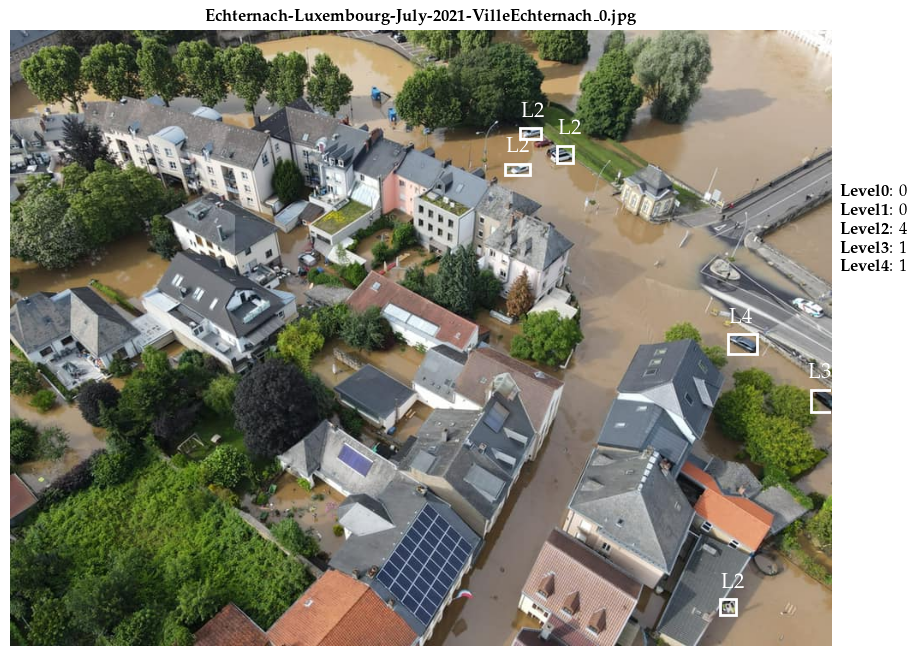

Annotated image saved to outputs/article_oblique/annotated_images/Echternach-Luxembourg-July-2021-VilleEchternach_0.jpg
YOLO annotation saved to outputs/article_oblique/levels_yolo_annotations/Echternach-Luxembourg-July-2021-VilleEchternach_1.txt


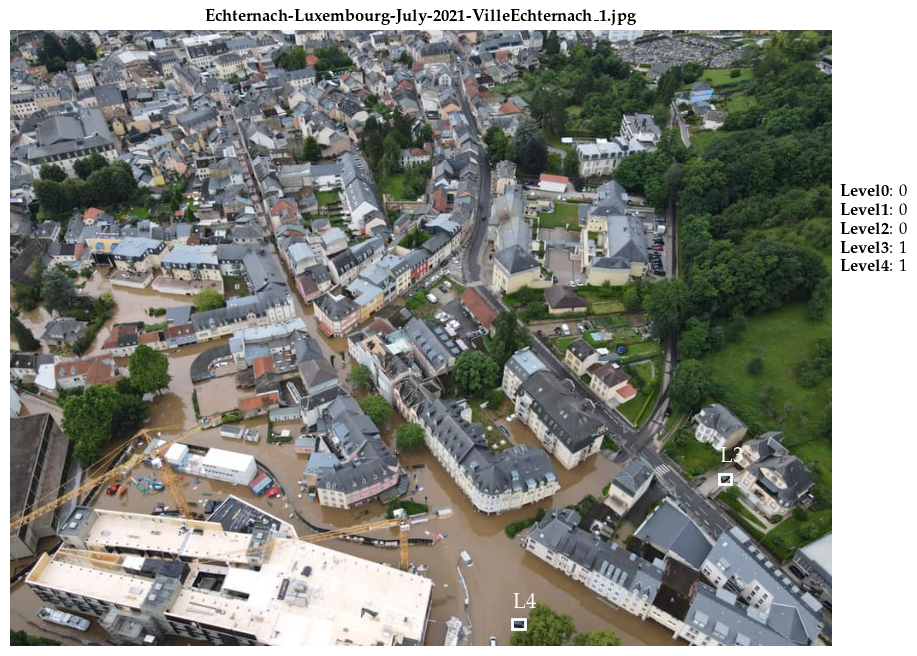

Annotated image saved to outputs/article_oblique/annotated_images/Echternach-Luxembourg-July-2021-VilleEchternach_1.jpg


02/26/2025 18:32:03 - WARNING - adjustText -   Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


YOLO annotation saved to outputs/article_oblique/levels_yolo_annotations/Echternach-Luxembourg-July-2021-VilleEchternach_2.txt


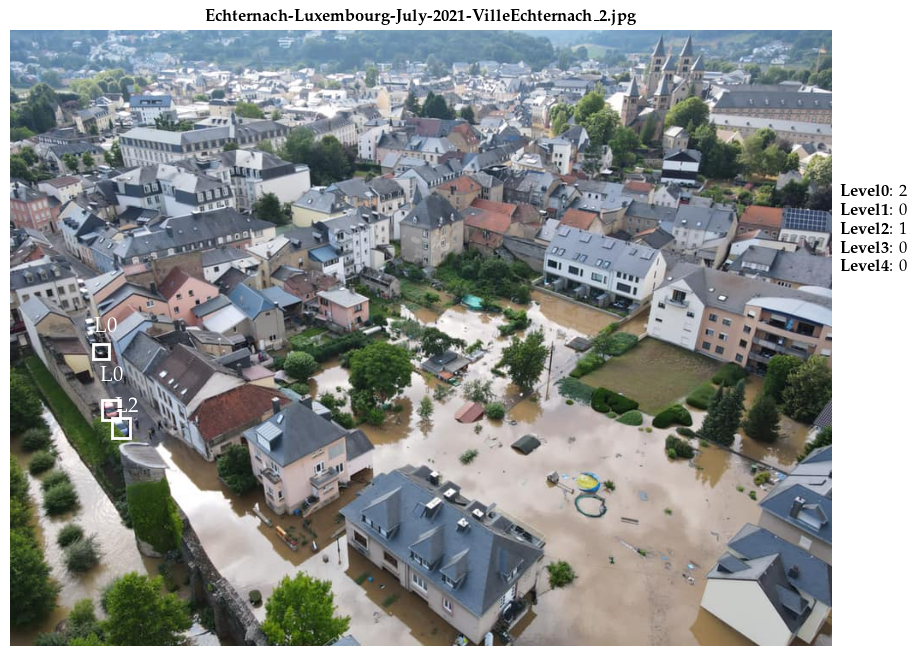

Annotated image saved to outputs/article_oblique/annotated_images/Echternach-Luxembourg-July-2021-VilleEchternach_2.jpg


In [42]:
LEVELS_YOLO_ANNOTATIONS_DIR = f"{OUTPUT_DIR}/levels_yolo_annotations/"
os.makedirs(LEVELS_YOLO_ANNOTATIONS_DIR, exist_ok=True)

CLASS_LABELS_TO_ID = {label: idx for idx, label in enumerate(CLASS_LABELS)}

# Load classification results
df = pd.read_csv(ic_csv_path)

# Extract original image name and detection index
df["original_image"] = df["image_path"].apply(lambda x: "_".join(os.path.basename(x).split("_")[:-1]) + ".jpg")
df["detection_index"] = df["image_path"].apply(lambda x: int(os.path.basename(x).split("_")[-1].split(".")[0]))

# Iterate through each image
for image_file in os.listdir(ORIGINAL_IMAGE_DIR):
    if not image_file.lower().endswith(IMAGE_EXTENSIONS):
        continue  # Skip non-image files

    image_path = os.path.join(ORIGINAL_IMAGE_DIR, image_file)
    label_path = os.path.join(LABEL_DIR, os.path.splitext(image_file)[0] + ".txt")
    lvl_yolo_annotation_path = os.path.join(LEVELS_YOLO_ANNOTATIONS_DIR, os.path.splitext(image_file)[0] + ".txt")

    if not os.path.exists(label_path):
        print(f"Skipping {image_file}: No YOLO-World labels found.")
        continue

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping {image_file}: Could not load image.")
        continue

    # Load YOLO labels (bounding boxes)
    with open(label_path, "r") as f:
        detections = [list(map(float, line.strip().split())) for line in f]

    if not detections:
        print(f"Skipping {image_file}: No detections found.")
        continue

    # Filter classifications for this image and sort by detection index
    image_df = df[df["original_image"] == image_file].sort_values(by="detection_index")

    # Class counts
    class_counts = {level: 0 for level in df.columns[2:-2]}  # Dynamically get class labels

    img_height, img_width = image.shape[:2]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(rf"\textbf{{{image_file}}}")
    ax.axis("off")

    text_annotations = []  # Store text annotations for adjustment
    yolo_annotations = []  # Store YOLO-formatted annotations

    for (detection, (_, row)) in zip(detections, image_df.iterrows()):
        class_id, x_center, y_center, width, height = detection
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        predicted_label = row["predicted_label"]
        probability = row[predicted_label]  # Get confidence score

        class_counts[predicted_label] += 1
        yolo_class_id = CLASS_LABELS_TO_ID[predicted_label]  # Get corresponding class ID

        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="white", facecolor="none"))

        # Convert to YOLO format (normalized coordinates)
        yolo_x_center = x_center
        yolo_y_center = y_center
        yolo_width = width
        yolo_height = height
        yolo_annotations.append(f"{yolo_class_id} {yolo_x_center:.6f} {yolo_y_center:.6f} {yolo_width:.6f} {yolo_height:.6f} {probability:.4f}")

        label_text = f"{predicted_label.replace('Level', 'L')}"
        text_annotations.append(ax.text(x1, y1 - 10, label_text, fontsize=15, color="white"))

    adjust_text(
        text_annotations,
        expand_points=(1.2, 1.4),
        arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
    )

    class_text = "\n".join([rf"\textbf{{{k}}}: {v}" for k, v in class_counts.items()])
    plt.text(img_width + 10, img_height // 4, class_text, fontsize=12, verticalalignment="top", color="black")

        # Save YOLO-formatted labels
    with open(lvl_yolo_annotation_path, "w") as f:
        f.write("\n".join(yolo_annotations))
    print(f"YOLO annotation saved to {lvl_yolo_annotation_path}")

    output_image_path = os.path.join(ANNOTATED_IMG_DIR, image_file)
    plt.savefig(output_image_path, bbox_inches="tight", pad_inches=0.2)
    plt.show()

    print(f"Annotated image saved to {output_image_path}")
